<a href="https://colab.research.google.com/github/alexandragrecu/Bark-and-Purr/blob/master/Sentiment_analysis_NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment analysis - Romanian reviews**
## NLP project - May 2022
### Student: Alexandra Grecu - Software Engineering - 406

## **Introduction**
Sentiment analysis is the process of understanding the opinion of an author about a subject. It answers the question: "*How does the author of the text feel about this subject?* 🤔"

Consider the following phrases:
1. The Godfather is a great movie.🙂
2. The Godfather is not a great movie.😠
3. The Godfather is a movie. 😐

Each sentence corresponds to a movie review and expresses a different emotion. For example, the first sentence denotes a positive sentiment about the movie, the second expresses negative emotions about the movie, and the third one is an example of neutral sentiment (There is not a single word in the sentence that can tell us anything about the sentiment it conveys).

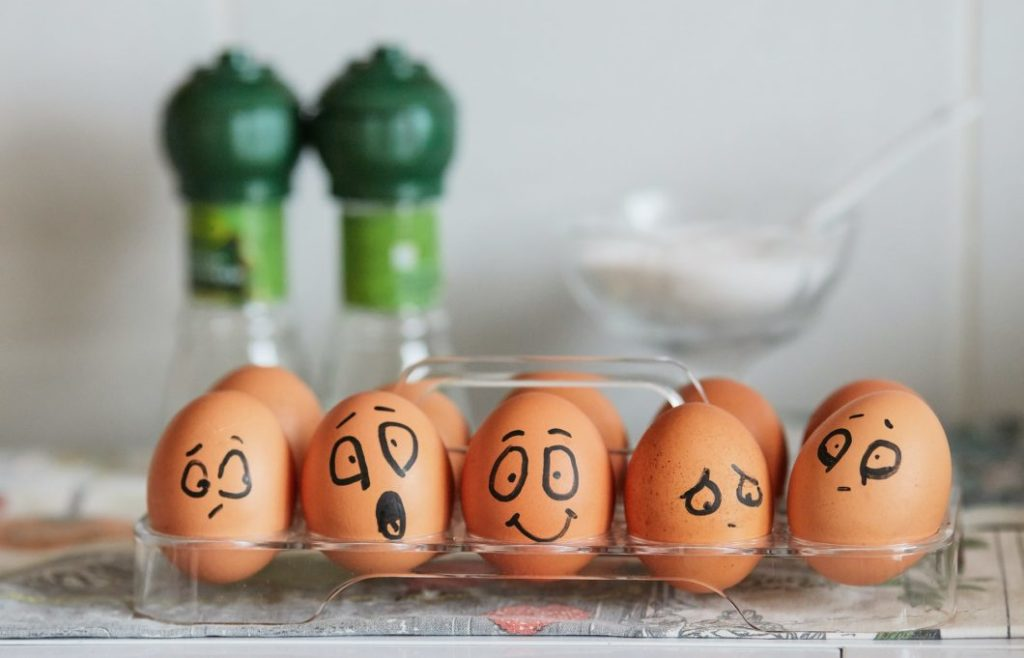

A sentiment analysis project is a combination of Natural Language Processing and Machine Learning algorithms. In the next sections, we will use NLP and ML for **analysing sentiments for movies and product reviews in Romanian language**.



## **Describing the DataSet**

In general, quality datasets are not easy to find (especially in Romanian language), but I was lucky to find a labeled dataset for reviews of movies and products made by Romanian people (first I found the dataset, then I chose the project :) ). The dataset was created by [Romanian Transformers](https://github.com/dumitrescustefan/Romanian-Transformers) who used it in their examples of Sentiment Analysis projects.

A detailed description of the dataset can be found [here](https://huggingface.co/datasets/ro_sent) and  from this [Github repository](https://github.com/katakonst/sentiment-analysis-tensorflow) you can download the dataset.

I've already downloaded the dataset, I took the first **2000 reviews** (1000 positive reviews and 1000 negative reviews) and you can see the dataset [here](https://drive.google.com/drive/folders/1lpZHQUSdCbCqNI2doeVmqtL0mqDIkZrP?usp=sharing).

The dataset contains 2 columns:


*  ` review` - the review for the products and movies
*   `label` - `1 for positive reviews` and `0 for negative reviews`

On the other hand, I needed a list of Romanian stopwords for language processing. I have found it [here](https://github.com/Alir3z4/stop-words/blob/master/romanian.txt).

Obs! I will import the processed dataset directly, but at the end of this project I will attach the code I wrote for reading the reviews, trasformed them in a csv file and export that file. (The raw dataset found on github is formed by 7000 text files containing one review each).

## **Sentiment Analysis**

### **1. Import packages**

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.stem.snowball import SnowballStemmer
RomanianStemmer = SnowballStemmer("romanian")

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import tree
from sklearn import svm

from google.colab import files

from wordcloud import WordCloud
from functools import reduce

from nltk import word_tokenize
import nltk
nltk.download("punkt")

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import re


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **2. Upload the Reviews csv file and the Romanian stopwords file**

In [2]:
# upload the reviews dataset
uploaded = files.upload()

Saving my_data4.csv to my_data4.csv


In [3]:
# upload the file containing all romanian stopwords.
uploaded = files.upload()

Saving romanian.txt to romanian.txt


In [4]:
romanian_stop_words = pd.read_csv('romanian.txt', names=['word'],  lineterminator='\n', header=None)

In [5]:
romanian_stop_words.head()

,word
0,vreo
1,acelea
2,cata
3,cita
4,degraba


In [6]:
reviews = pd.read_csv('my_data4.csv')

In [7]:
reviews.head()

,review,label
0,ar trebui sa cieasca si cartea.........,1
1,superb...........................................,1
2,deci daca v-ati aruncat aiurea pe varianta de ...,1
3,excelent\ntelefonul este intact:),1
4,excelent\neste original,1


In [8]:
# example of positive review
reviews.iloc[250, 0]

'cu siguranta una dintre capodoperele lui cameron...'

In [9]:
# example of negative review
reviews.iloc[1084, 0]

' specific poate liceenilor. dezamagitor !'

### Do we have any missing values in the dataset?

In [10]:
reviews.isna().sum()

review    0
label     0
dtype: int64

### How many positive and negative reviews do we have? -> We can see we almost have the same proportion of negative and positive reviews.

In [11]:
reviews['label'].value_counts()

0    989
1    949
Name: label, dtype: int64

In [12]:
romanian_stop_words = romanian_stop_words['word']

### From what we can see, there are some words that repeat a lot but they do not help us identify if the reviews are positive or negative, we will add them to stopwords set:

In [13]:
romanian_stop_words = romanian_stop_words.append(pd.Series(['film', 'filmul', 'filmu', 'filme', 'telefon', 'pt', 'cartea', 'produs', 'br', 't3']), ignore_index=True)

In [14]:
romanian_stop_words = frozenset(romanian_stop_words)

In [63]:
reviews.iloc[[940, 941, 942, 951, 952, 965], :]

,review,label,nr_words
940,este cu adevarat o capodopera din punctul meu...,1,13
941,super film.super actori.super efecte.film de v...,1,9
942,pentru ca este de ajuns sa te uiti la film ca...,1,46
951,aproape la fiecare aplicatie face pauza si da...,0,22
952,prostie!!!ce mai e si asta?pacat de regizor ca...,0,23
965,slab. mi-am irosit timpul uitandu-ma la el.,0,9


### 3. **Creating a Word Cloud with words that occur most frequenly in positive reviews:**

In [15]:
positive_reviews = reviews[reviews["label"] == 1]["review"][:400]  # 1 = positive, 0 = negative
positive_reviews = reduce(lambda a, b: a + b, positive_reviews)
positive_reviews

'ar trebui sa cieasca si cartea.........superb....................................................................................................................deci daca v-ati aruncat aiurea pe varianta de la cinema fara efecte 3d ati stricat tot filmul... mergeti la 3d!!! eu am fost de doua ori la 3d si cred ca nu ma opresc... ca fapt divers.excelent\ntelefonul este intact:)excelent\neste originalun film de nota 10 felicitari lui james cameron un mare regizor atunci cand esti sigura de ceea ce ti se potriveste.dar in rest totul e perfect ! se aude foarte tare si clarsamsung\nsamsung.... .... .... cel mai bun film. e extraordinar.o boxa buna\nam cumparat-o cam de o saptamana. nu am folosit-o prea mult. pot sa zic ca pt o chestie asa mica scoate un sunet ok. bassul e ok. se aude tare. e suficienta pt o camera de bloc. eu am luat-o ca resigilata varianta gri la 100 lei. un chilipir parerea mea. evident ca nu avea cum sa mearga.filmul o sa fie o capodopera fara indoiala. ........:dun fi

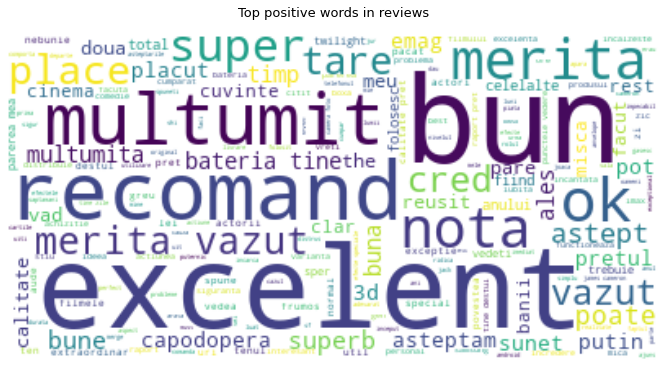

In [16]:
word_cloud_positive = WordCloud(background_color="white", stopwords=romanian_stop_words).generate(positive_reviews) # remove the stopwords

plt.figure(figsize=(12, 6))
plt.title("Top positive words in reviews", y=1.04, size=13) 
plt.axis("off") 
plt.imshow(word_cloud_positive, interpolation="bilinear")

plt.show()

## **4. Text preprocessing:**
  - tokenize words
  - stemming (words like "filmu", "filmuletul", "filmuuu" -> "film")
  - eliminate emojis
  - lowercase all words
  - remove punctuation

In [17]:
def stemming_tokenizer(str_input):
  '''Stemming function: tokenize + stemming all words + eliminate punctuation,
   emojis, and all characters except numbers and words + lowercase words'''

  words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
  words = [RomanianStemmer.stem(word) for word in words]
  return words

In [18]:
# check to see if the stemming function works well
stemming_tokenizer("Casuta 23 este frumusica.")

['casut', '23', 'este', 'frumus']

In [19]:
# adding a new column to our dataset: number of words, even though I will not use it, 
# in other analysis it can be useful.

# tokenize 
word_tokens = [word_tokenize(review) for review in reviews.review]

# create a new feature for the lenght of each review
reviews['nr_words'] = [len(word_tokens[i]) for i in range(len(word_tokens))]

reviews.head()

,review,label,nr_words
0,ar trebui sa cieasca si cartea.........,1,9
1,superb...........................................,1,40
2,deci daca v-ati aruncat aiurea pe varianta de ...,1,43
3,excelent\ntelefonul este intact:),1,6
4,excelent\neste original,1,3


### **5. Build a vectorizer - using Tfidf**

In [20]:
vect = TfidfVectorizer(stop_words=romanian_stop_words, 
                       tokenizer=stemming_tokenizer,
                       ngram_range=(1, 2), # unigrams and bigrams
                       max_features= 200, 
                       token_pattern=r"\b[^\W][^\W]+\b") # just words and numbers

In [21]:
vect.fit(reviews['review'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abi', 'ace', 'aceast', 'aceeas', 'acei', 'acelas', 'adic', 'aic', 'aiur', 'alatur', 'altcev', 'anum', 'apo', 'asemen', 'astaz', 'asupr', 'atar', 'atunc', 'ave', 'bin', 'car', 'carei', 'caror', 'cart', 'carui', 'catev', 'cativ', 'catr', 'cee', 'ceilalt', 'cev', 'cin', 'cinev', 'citev', 'citiv', 'cumv', 'dac', 'deasupr', 'dec', 'degrab', 'dej', 'des', 'despr', 'dup', 'fac', 'far', 'fat', 'foart', 'geab', 'inaint', 'inapo', 'intruc', 'mar', 'nic', 'niciod', 'nimen', 'nist', 'nostr', 'numa', 'oric', 'pan', 'parc', 'pest', 'pin', 'pre', 'putin', 'sa-m', 'sa-t', 'sal', 'toat', 'to

TfidfVectorizer(max_features=200, ngram_range=(1, 2),
                stop_words=frozenset({'a', 'abia', 'acea', 'aceasta', 'aceea',
                                      'aceeasi', 'aceia', 'acel', 'acela',
                                      'acelasi', 'acelea', 'acest', 'acesta',
                                      'aceste', 'acestea', 'acestei', 'acestia',
                                      'acestui', 'acolo', 'acum', 'adica', 'ai',
                                      'aia', 'aici', 'aiurea', 'al', 'ala',
                                      'alaturi', 'ale', 'alt', ...}),
                token_pattern='\\b[^\\W][^\\W]+\\b',
                tokenizer=<function stemming_tokenizer at 0x7f89bb3dca70>)

In [22]:
X = vect.transform(reviews['review'])

In [23]:
# create a dataframe 
reviews_transformed = pd.DataFrame(data=X.toarray(), columns=vect.get_feature_names_out())
reviews_transformed

,-,1,10,2,3,3d,4,5,abi,abi astept,...,vedet,vez,viat,vizion,vre,x,x x,zi,zic,zil
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.794482,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1934,0.0,0.0,0.0,0.373867,0.0,0.000000,0.0,0.0,0.228511,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220817,0.0
1935,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1936,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


In [24]:
reviews_aux = reviews.drop(['review', 'nr_words'], axis=1)
reviews_transformed = pd.concat([reviews_aux, reviews_transformed], axis=1)

In [25]:
reviews_transformed

,label,-,1,10,2,3,3d,4,5,abi,...,vedet,vez,viat,vizion,vre,x,x x,zi,zic,zil
0,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,1,0.0,0.0,0.0,0.000000,0.0,0.794482,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1934,0,0.0,0.0,0.0,0.373867,0.0,0.000000,0.0,0.0,0.228511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.220817,0.0
1935,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1936,0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


### **6. Training and Testing Different models:**
 We will use the following classifiers:
 - Logistic Regression
 - Nave Bayes
 - Decisional Tree
 - SVM

In [26]:
y = reviews_transformed["label"]
X = reviews_transformed.drop("label", axis=1)

We will split the dataset in 80% training set and 20% testing set:


In [27]:
# train/test split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2,
                                                    random_state=456, 
                                                    stratify=y)

In [28]:
X_test.value_counts()

-         1    10   2    3    3d   4    5    abi  abi astept  aceast  actiun  actor  adevar  aic  ales  an   ani  apar  arat  astept  asteptar  atunc  aud  avet  ban  bater  bater tin  bin       box  bun  calitat  calitat pret  cameron  capodoper  car       cart  catev  cee  cev  cin  cinem  citit  comed  cred      cumpar    dac       dau  dec  deloc  des  despr  dest  dezamag  dou  dup  e    e bun  e foart  efect  efect special  emag  excelent  excelent foart  fac       facut  fan  fapt  far       fat  fiec  final  foart     foart bin  foart bun  foart multum  foart slab  folos  frumos  functioneaz  garant  gen  greu  inaint    incant  incep  incred  intampl  inteleg   interes  l-am  l-am vazut  las       lei  luat  lucru     lum  lun  m-am  macar  mar  matrix  mea  merg  merit     merit ban  merit vazut  meu  mi-  mi- placut  mic  mie  min  minut  miros  misc  multum    nic  nic macar  nist  normal  not       not 10  numa  oamen  ok   ore  oric  original  pacat  pan  par  parer  pare

### **6.1 In this section we will define different functions for plotting, printing and working with the chosen classifiers:**

In [29]:
def get_params(penalty, C, random_state):
  return {
      "penalty": penalty,
      "C": C,
      "random_state": random_state
  }

In [30]:
def plot_confusion_matrix(clf, y_predicted):
  ''' Plot confusion matrix in two forms: % and integers.'''

  cnf_matrix = confusion_matrix(y_test, y_predicted)
  
  fig, ax =plt.subplots(1,2)
  fig.set_size_inches(8, 4)

  sns.heatmap(cnf_matrix, 
              annot=True, 
              fmt="g", ax=ax[0]).set(title="Confusion Matrix", 
                                     ylabel="Actual label", 
                                     xlabel="Predicted label")

  sns.heatmap(cnf_matrix/np.sum(cnf_matrix), 
              annot=True, 
              fmt='.2%', 
              cmap='Blues',
              ax=ax[1]).set(title="Confusion Matrix",
                            ylabel="Actual label", 
                            xlabel="Predicted label")

  plt.tight_layout()

  plt.show()


In [31]:
def get_metrics(y_predicted):
  '''Return the accuracy, precision and recall scores.'''

  return (accuracy_score(y_test, y_predicted), precision_score(y_test, y_predicted), recall_score(y_test, y_predicted))

In [32]:
def print_metrics(a, p, r):
  '''Print the metrics.'''
  
  print("Accuracy:", a)
  print("Precision:", p)
  print("Recall:", r)

In [33]:
def get_logistic_regression_clf(params):
  '''Logistic regression classifier'''
  
  # Train a logistic regression
  log_reg = LogisticRegression(**params, max_iter=1000).fit(X_train, y_train)

  # Predict the labels
  y_predicted = log_reg.predict(X_test)

  # plot the confusion matrix
  plot_confusion_matrix(log_reg, y_predicted)

  # plot RocCurve
  RocCurveDisplay.from_estimator(log_reg, X_test, y_test)

  return get_metrics(y_predicted)

In [34]:
def get_naive_bayes_clf():
  '''Naive Bayes Classifier'''
  
  clf = MultinomialNB()
  clf.fit(X_train, y_train)

  # Predict the labels
  y_predicted = clf.predict(X_test)

  # plot the confusion matrix
  plot_confusion_matrix(clf, y_predicted)

  # plot RocCurve
  RocCurveDisplay.from_estimator(clf, X_test, y_test)

  return get_metrics(y_predicted)

In [35]:
def hyperparameter_tuning_dt():
  '''hyperparameter tuning fo decisional trees with random search'''

  rs_param_grid = {
    "criterion": ["gini", "entropy"],
    "max_depth": list((range(3, 12))),
    "min_samples_split": list((range(2, 5))),
    "min_samples_leaf": list((range(1, 5))),
    "ccp_alpha": [0, 0.001, 0.01, 0.1],
  }

  clf = DecisionTreeClassifier(random_state=123)

  clf_rs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=10,  # Number of parameter candidate settings to sample
    verbose=2,  # The higher this is, the more messages are outputed
    random_state=123,
  )
  clf_rs.fit(X_train, y_train)

  return (clf_rs.best_params_, clf_rs.best_score_)


In [36]:
def get_decision_tree_clf():
  '''Decision tree classifier'''
  
  params, score = hyperparameter_tuning_dt()

  clf = DecisionTreeClassifier(**params)
  clf = clf.fit(X_train, y_train)

  # Predict the labels
  y_predicted = clf.predict(X_test)

  # plot the confusion matrix
  plot_confusion_matrix(clf, y_predicted)

   # plot RocCurve
  RocCurveDisplay.from_estimator(clf, X_test, y_test)

  metrics = get_metrics(y_predicted)
  best_params = params
  
  return (metrics, params)

In [37]:
def hyperparameter_tuning_svm():
  '''hyperparameter tuning for SVM'''
  
  rs_param_grid = {
    "kernel": ["linear", "poly", "rbf", "sigmoid"],
    "C": [0.1, 1, 10],
    "gamma": [0.00001, 0.0001, 0.001, 0.01, 0.1],
  }

  # Create a svm.SVC object
  clf = svm.SVC(random_state=123)

  # Instantiate RandomizedSearchCV() with clf and the parameter grid
  clf_rs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=rs_param_grid,
    cv=3,  # Number of folds
    n_iter=5,  # Number of parameter candidate settings to sample
    verbose=2,  # The higher this is, the more messages are outputed
    random_state=123,
  )

  # Train the model on the training set
  clf_rs.fit(X_train, y_train)

  return (clf_rs.best_params_, clf_rs.best_score_)

In [38]:
def get_svm_clf():
  '''SVM classifier'''
  
  params, score = hyperparameter_tuning_svm()

  clf = svm.SVC(random_state=123)
  # Instantiate RandomizedSearchCV() with clf and the parameter grid
  clf_rs = RandomizedSearchCV(
    estimator=clf,
    param_distributions=params,
    cv=3,  # Number of folds
    n_iter=5,  # Number of parameter candidate settings to sample
    verbose=2,  # The higher this is, the more messages are outputed
    random_state=123,
  )

  clf = clf.fit(X_train, y_train)

  # Predict the labels
  y_predicted = clf.predict(X_test)

  # plot the confusion matrix
  plot_confusion_matrix(clf, y_predicted)

  # plot RocCurve
  RocCurveDisplay.from_estimator(clf, X_test, y_test)

  metrics = get_metrics(y_predicted)
  best_params = params
  return (metrics, params)

### **7. Results:**

#### 7.1 Logistic Regression with parameters:
- penalty: l2
- C: 1
- random_state: 123

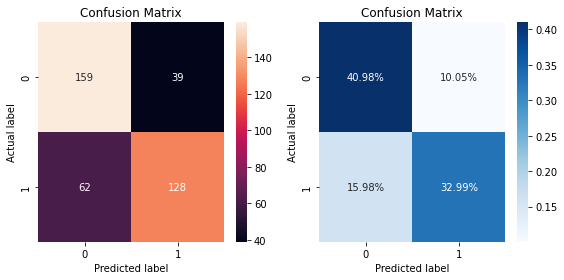

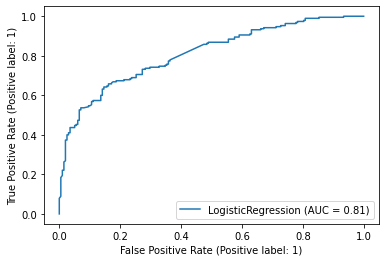

In [39]:
accuracy_lr, precision_lr, recall_lr = get_logistic_regression_clf({ "penalty": "l2", "C": 1, "random_state": 123})

In [40]:
print_metrics(accuracy_lr, precision_lr, recall_lr)

Accuracy: 0.7396907216494846
Precision: 0.7664670658682635
Recall: 0.6736842105263158


#### 7.2 Logistic Regression with parameters:
- penalty: l2
- C: 100
- random_state: 123

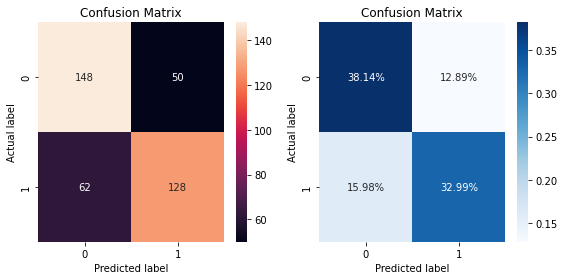

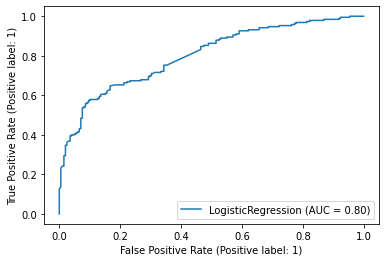

In [41]:
# Train a logistic regression
accuracy_lr2, precision_lr2, recall_lr2 = get_logistic_regression_clf({ "penalty": "l2", "C": 100, "random_state": 123})

In [42]:
print_metrics(accuracy_lr2, precision_lr2, recall_lr2)

Accuracy: 0.711340206185567
Precision: 0.7191011235955056
Recall: 0.6736842105263158


### 7.2 Naive Bayes

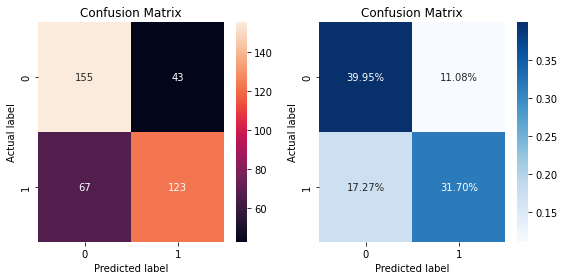

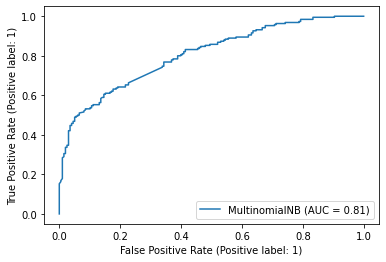

In [43]:
accuracy_nb, precision_nb, recall_nb = get_naive_bayes_clf()

In [44]:
print_metrics(accuracy_nb, precision_nb, recall_nb)

Accuracy: 0.7164948453608248
Precision: 0.7409638554216867
Recall: 0.6473684210526316


### 7.3 Decision Tree

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=3; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=3; total time=   0.0s
[CV] END ccp_alpha=0.1, criterion=entropy, max_depth=7, min_samples_leaf=4, min_samples_split=3; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=2; total time=   0.0s
[CV] END ccp_alpha=0.01, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=2; total time=   0.0s
[CV] END 

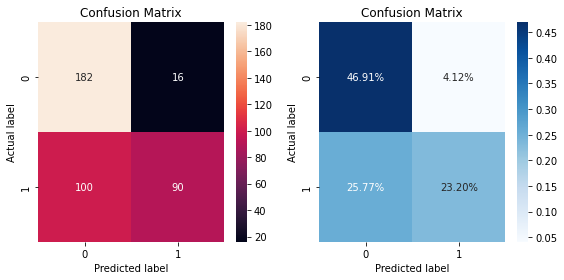

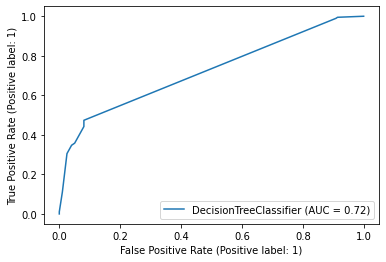

In [45]:
metrics, best_params = get_decision_tree_clf()

In [46]:
accuracy_dt, precision_dt, recall_dt = metrics
print_metrics(accuracy_dt, precision_dt, recall_dt)

Accuracy: 0.7010309278350515
Precision: 0.8490566037735849
Recall: 0.47368421052631576


In [47]:
print("Best params for DT:", best_params)

Best params for DT: {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9, 'criterion': 'gini', 'ccp_alpha': 0.001}


### 7.4 SVM

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END ...................C=1, gamma=0.0001, kernel=linear; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.2s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=1, gamma=0.1, kernel=sigmoid; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.2s
[CV] END ..................C=0.1, gamma=0.01, kernel=sigmoid; total time=   0.2s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.2s
[CV] END ...................C=1, gamma=0.001, kernel=sigmoid; total time=   0.2s
[CV] END ...................C=1, gamma=0.001, ker

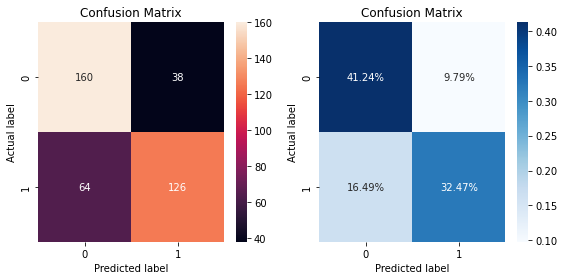

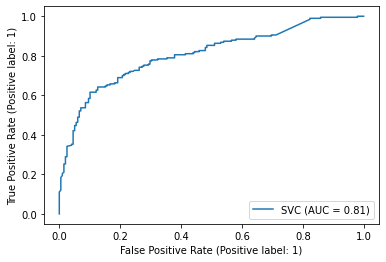

In [48]:
metrics, best_params = get_svm_clf()

In [49]:
accuracy_svm, precision_svm, recall_svm = metrics
print_metrics(accuracy_svm, precision_svm, recall_svm)

Accuracy: 0.7371134020618557
Precision: 0.7682926829268293
Recall: 0.6631578947368421


In [50]:
print("Best params for SVM:", best_params)

Best params for SVM: {'kernel': 'linear', 'gamma': 0.0001, 'C': 1}


In [51]:
results = {
    "classifier": ["Logistic Regression C=1", "Logistic Regression C=100", "Naive Bayes", "Decisional Tree", "SVM"],
    "accuracy": [accuracy_lr, accuracy_lr2, accuracy_nb, accuracy_dt, accuracy_svm],
    "precision": [precision_lr, precision_lr2, precision_nb, precision_dt, precision_svm],
    "recall": [recall_lr, recall_lr2, recall_nb, recall_dt, recall_svm]
    }

In [52]:
results = pd.DataFrame(results)

## **8. Final Results:**

In [53]:
results

,classifier,accuracy,precision,recall
0,Logistic Regression C=1,0.739691,0.766467,0.673684
1,Logistic Regression C=100,0.711340,0.719101,0.673684
2,Naive Bayes,0.716495,0.740964,0.647368
3,Decisional Tree,0.701031,0.849057,0.473684
4,SVM,0.737113,0.768293,0.663158


### From our analysis, we can see that Logistic Regression (with parameters: penalty: l2, C:1, random_state:123) has the highest accuracy (73,96%).

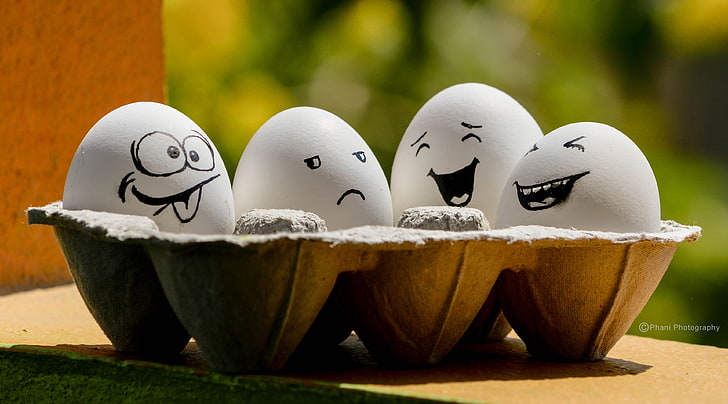



---



---



Code for reading and processing the dataset:

In [54]:
'''
import pandas as pd
import os
import glob
import csv

# get the positive reviews
my_dir = "C:\\Users\\User\\Desktop\\sentiment_analysis\\positive_reviews_folder\\"
filelist = []
filesList = []
os.chdir( my_dir )

for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filelist.append(fileName) 
    filesList.append(files) 

df = pd.DataFrame()
df = pd.concat([pd.read_csv(item, names=["review"], lineterminator="|", 
                            engine="c", 
                            quoting=csv.QUOTE_NONE, 
                            dtype = str) 
                            for item in filesList], axis=0)

# add label column with value 1 (positive reviews)
df['label'] = 1
df.shape


# get the negative reviews
my_dir = "C:\\Users\\User\\Desktop\\sentiment_analysis\\negative_reviews_folder\\"
filelist = []
filesList = []
os.chdir( my_dir )

for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filelist.append(fileName) 
    filesList.append(files)

df2 = pd.DataFrame()
df2 = pd.concat([pd.read_csv(item, names=["review"], quoting=csv.QUOTE_NONE, 
                             lineterminator="|", 
                             engine="c",
                             dtype = str) 
                             for item in filesList], axis=0)

# add label column with value 0 (negative reviews)
df2['label'] = 0
df2.shape

# concat the 2 dataframes
df3 = pd.concat([df, df2])
df3.shape

df3.review.isna().sum()
df3 = df3.dropna()

# convert and export
df3.to_csv(r"C:\\Users\\User\\Desktop\\sa\\my_data4.csv", index=False)
reviews = pd.read_csv("C:\\Users\\User\\Desktop\\sa\\my_data4.csv")

reviews.head()
'''

'\nimport pandas as pd\nimport os\nimport glob\nimport csv\n\n# get the positive reviews\nmy_dir = "C:\\Users\\User\\Desktop\\sentiment_analysis\\positive_reviews_folder\\"\nfilelist = []\nfilesList = []\nos.chdir( my_dir )\n\nfor files in glob.glob("*.txt"):\n    fileName, fileExtension = os.path.splitext(files)\n    filelist.append(fileName) \n    filesList.append(files) \n\ndf = pd.DataFrame()\ndf = pd.concat([pd.read_csv(item, names=["review"], lineterminator="|", \n                            engine="c", \n                            quoting=csv.QUOTE_NONE, \n                            dtype = str) \n                            for item in filesList], axis=0)\n\n# add label column with value 1 (positive reviews)\ndf[\'label\'] = 1\ndf.shape\n\n\n# get the negative reviews\nmy_dir = "C:\\Users\\User\\Desktop\\sentiment_analysis\\negative_reviews_folder\\"\nfilelist = []\nfilesList = []\nos.chdir( my_dir )\n\nfor files in glob.glob("*.txt"):\n    fileName, fileExtension = os.path.s